In [1]:
from ultralytics import YOLO
import torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt

from model_cnn_transformer import OCRModel
from dataset_polygon import char2idx, idx2char

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VOCAB_SIZE = len(char2idx)
OCR_MODEL_PATH = "best_ocr_model.pth"
YOLO_MODEL_PATH = "runs/detect/train/weights/best.pt"

In [2]:
from torchvision import transforms


def preprocess_ocr_image(pil_img):
    transform = transforms.Compose(
        [
            transforms.Resize((32, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transform(pil_img).unsqueeze(0)


def decode_sequence(indices):
    chars = []
    SOS_TOKEN = next((token for token in char2idx.keys() if "SOS" in token), None)
    for idx in indices:
        ch = idx2char.get(idx, "")
        if ch == "<EOS>":
            break
        if ch not in ("<PAD>", SOS_TOKEN):
            chars.append(ch)
    return "".join(chars)

In [3]:
# Load models
yolo_model = YOLO(YOLO_MODEL_PATH)
ocr_model = OCRModel(vocab_size=VOCAB_SIZE).to(DEVICE)
ocr_model.load_state_dict(torch.load(OCR_MODEL_PATH, map_location=DEVICE))
ocr_model.eval()

FONT_PATH = "Roboto-Regular.ttf"


def draw_vietnamese_boxes_text(img_pil, bboxes, texts, font_size=18):
    draw = ImageDraw.Draw(img_pil)
    font = ImageFont.truetype(FONT_PATH, font_size)
    for (x1, y1, x2, y2), txt in zip(bboxes, texts):
        draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)
        draw.text((x1, max(y1 - 22, 0)), txt, fill=(255, 0, 0), font=font)
    return img_pil


def yolo_ocr_pipeline(image_path, show_image=True):
    # 1. Detection
    results = yolo_model(image_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()  # confidence scores
    filtered = [(box, conf) for box, conf in zip(boxes, confs) if conf > 0.5]
    boxes = [box for box, conf in filtered]

    # 2. Crop từng bbox và nhận diện text
    img_pil = Image.open(image_path).convert("RGB")
    texts = []
    bboxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = img_pil.crop((x1, y1, x2, y2))
        image_tensor = preprocess_ocr_image(crop).to(DEVICE)
        with torch.no_grad():
            memory = ocr_model.encoder(image_tensor)
            SOS_TOKEN = next(
                (token for token in char2idx.keys() if "SOS" in token), None
            )
            MAX_LEN = 36
            ys = torch.tensor([[char2idx[SOS_TOKEN]]], device=DEVICE)
            for _ in range(MAX_LEN):
                out = ocr_model.decoder(
                    ys,
                    memory,
                    tgt_mask=ocr_model.generate_square_subsequent_mask(ys.size(1)).to(
                        DEVICE
                    ),
                )
                prob = out[:, -1, :]
                _, next_word = torch.max(prob, dim=1)
                ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)
                if next_word.item() == char2idx["<EOS>"]:
                    break
            pred_text = decode_sequence(ys.squeeze(0).tolist())
            texts.append(pred_text)
            bboxes.append((x1, y1, x2, y2))

    # 3. Hiển thị kết quả
    if show_image:
        img_vn = draw_vietnamese_boxes_text(img_pil.copy(), bboxes, texts, font_size=15)
        plt.figure(figsize=(16, 12))
        plt.imshow(img_vn)
        plt.axis("off")
        plt.show()

    return list(zip(bboxes, texts))

c:\Users\NGUYEN\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NGUYEN\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



image 1/1 c:\Users\NGUYEN\Desktop\vietnamese-resnet-transformer-ocr\hinh-anh-30-4-25-1.jpg: 384x640 12 texts, 238.8ms
Speed: 5.4ms preprocess, 238.8ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


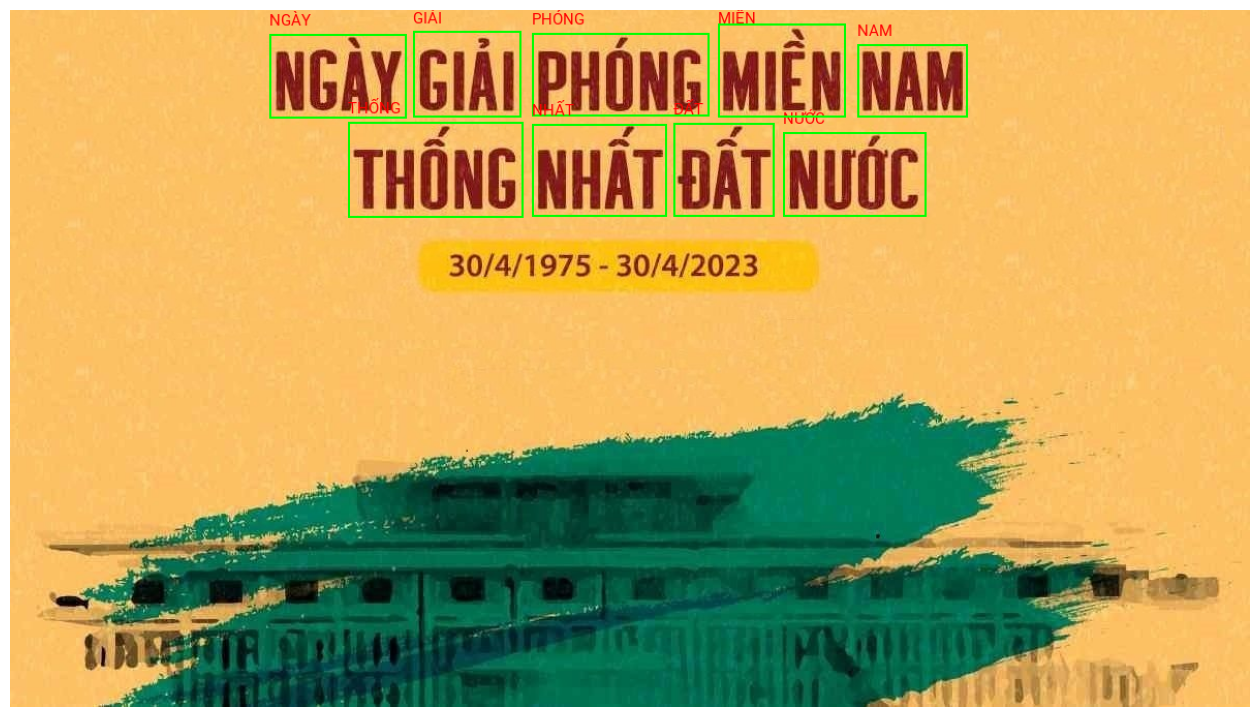

Bounding Box: (251, 24, 383, 105), Text: NGÀY
Bounding Box: (390, 21, 494, 104), Text: GIẢI
Bounding Box: (748, 119, 886, 200), Text: NƯỚC
Bounding Box: (642, 110, 739, 200), Text: ĐẤT
Bounding Box: (505, 23, 676, 103), Text: PHÓNG
Bounding Box: (327, 109, 496, 201), Text: THỐNG
Bounding Box: (820, 34, 926, 104), Text: NAM
Bounding Box: (505, 111, 635, 200), Text: NHẤT
Bounding Box: (685, 14, 808, 104), Text: MIỀN


In [12]:
# result = yolo_ocr_pipeline("vietnamese/unseen_test_images/im1510.jpg")
result = yolo_ocr_pipeline("./hinh-anh-30-4-25-1.jpg")
for bbox, text in result:
    print(f"Bounding Box: {bbox}, Text: {text}")